[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/guiwitz/MLCV/blob/main/notebooks/04-Data_handling.ipynb)
# 4. Handling data

In the previous chapter, we used data that were generated by a function and batched together manually. We would however like to avoid rewriting similar code, e.g. for batching, for each new dataset. To avoid this we can used two very useful tools of Pytorch called ```Dataset``` and ```DataLoader``` found in the ```from torch.utils.data``` module.

In [2]:
from torch.utils.data import Dataset, DataLoader

Just like for the Network with ```nn.Module``` both of these objects are used as basis on top of which to build and providing a series of very useful features.

In [1]:
# set path containing data folder or use default for Colab (/gdrive/My Drive)
local_folder = "../"
import urllib.request
urllib.request.urlretrieve('https://raw.githubusercontent.com/guiwitz/DLImaging/master/utils/check_colab.py', 'check_colab.py')
from check_colab import set_datapath
colab, datapath = set_datapath(local_folder)

## Dataset

Just like for the network with ```nn.Module``` we use here a base class ```Dataset``` that we extend for our own requirements. A ```Dataset``` simply provides samples as pairs of data and target. The only things we have to provide are 

1. a method returning the sample (```__getitem__```)
2. a method indicating the size of the dataset (```__len__```).

To test data handling and simple training, we created a test dataset with images of geometric objects and saved them as Numpy objects. We can reload them:

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [4]:
images = np.load(datapath.joinpath('data/triangle_circle.npy'))
labels = np.load(datapath.joinpath('data/triangle_circle_label.npy'))

In [5]:
images.shape

(50000, 32, 32)

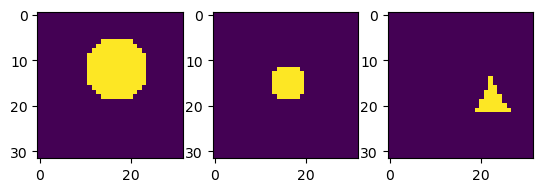

In [6]:
fig, axes = plt.subplots(1,3)
for ind, ax in enumerate(axes):
    ax.imshow(images[ind])

We use these objects as input to our ```Dataset``` object. Inside the object methods, we can perform the necessary pre-processing, e.g. in this case transforming the array to a tensor, rescaling etc.

In [7]:
class Tricircle(Dataset):
    def __init__(self, data, labels, transform=None):
        super(Tricircle, self).__init__()
        self.data = data
        self.labels = labels

    def __getitem__(self, index):
        
        x = self.data[index]
        x = torch.tensor(x/255, dtype=torch.float32)
        y = torch.tensor(self.labels[index])
        
        return x, y

    def __len__(self):

        return len(labels)

Here we provide the actual data as inputs to the ```Dataset``` but the data are often imported from within that object, as it is typically impossible to load all data in memory.

In [8]:
tridata = Tricircle(images, labels)

Now we can query items of our dataset by simple indexing:

In [9]:
myimage, mylabel = tridata[12]

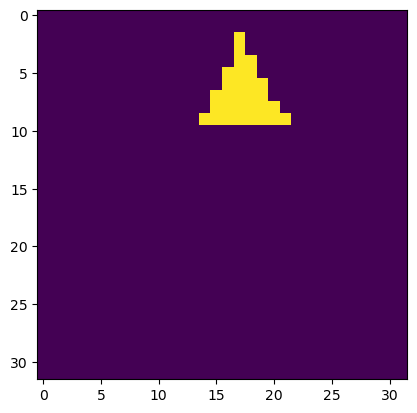

In [10]:
plt.imshow(myimage);

In [11]:
mylabel

tensor(0)

### Training and validation

Either we have prepared two datasets, one for training and one for validation, for example in two folders on disk, or we have one large dataset that we need to split. Here the ```random_split``` function comes in handy. We can for example directly apply it to our dataset object:

In [12]:
from torch.utils.data import random_split

In [13]:
test_size = int(0.8 * len(tridata))
valid_size = len(tridata)-test_size

In [14]:
train_data, valid_data = random_split(tridata, [test_size, valid_size])

In [15]:
len(train_data)

40000

In [16]:
len(valid_data)

10000

### Transforms

When creating a ```Dataset``` we can also directly pass a ```transform``` argument which is a series of pre-processing operation that should  be applied to the data when using them. We have seen previously that we could *compose* a transform using multiple operations e.g.:

In [17]:
import torchvision

transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomRotation(20)
])

We can now adjust our ```Dataset``` by including this transform:

In [18]:
class Tricircle(Dataset):
    def __init__(self, data, labels, transform=None):
        super(Tricircle, self).__init__()
        self.data = data
        self.labels = labels
        self.transform = transform

    def __getitem__(self, index):
        
        x = self.data[index]
        if self.transform is not None:
            x = self.transform(x)
        y = torch.tensor(self.labels[index])
        
        return x, y

    def __len__(self):

        return len(labels)

In [19]:
tridata = Tricircle(images, labels, transform=transforms)
myimage, mylabel = tridata[12]

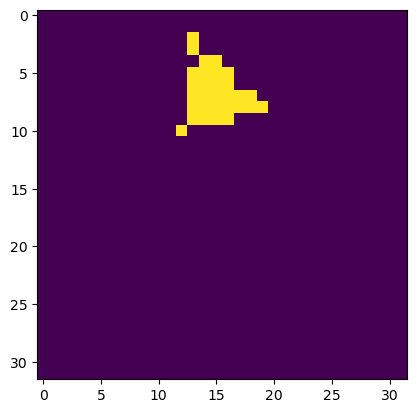

In [20]:
plt.imshow(myimage[0]);

## DataLoader

We can then pass this dataset to another base object called a ```DataLoader```. This object will take care of many things for us, in particular batching so that we don't have to do it manually anymore. In the simplest case we only need a ```Dataset``` and a batch size as input:

In [21]:
dataloader = DataLoader(tridata, batch_size=10)

```dataloader``` is an iterable, and therefore we can access elements using:

In [22]:
im_batch, label_batch = next(iter(dataloader))

Let's see if the size of the returned elements in the expected one:

In [23]:
im_batch.size()

torch.Size([10, 1, 32, 32])

In [24]:
label_batch.size()

torch.Size([10])

The ```DataLoader``` object has additional featues. For heavy import and pre-processing steps, we can e.g. load data in parallel with multiple workers.

Importantly we can also randomly shuffle samples around. This is crucial in the case where samples have a certain order e.g. if in the MNIST dataset we had first all 0'ss, 1's etc. If we would not randomly sample, we would train a model first the learn only 0's then 1's etc. and training would never succeed. In our example we can just say:

In [25]:
dataloader = DataLoader(tridata, batch_size=10, shuffle=True)

## Test datasets

Multiple libraries implement contain example datasets for example to test new architectures, or just that a setup works properly. Torchivision contains a module called dataset that provides several such examples. For example we can easily get the MNIST dataset:

In [26]:
import torchvision
mnist = torchvision.datasets.MNIST(
    root='/Users/gw18g940/Desktop/Test_data_courses/MLCVdata/', 
    download=True)

In [27]:
mnist[0]

(<PIL.Image.Image image mode=L size=28x28>, 5)

We see here that ```mnist``` is a ```Dataset```  object that returns here a PIL image and a label. Again, we would pass here a transform to make sure that we have properly formatted tensors:

In [28]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

mnist = torchvision.datasets.MNIST(
    root='/Users/gw18g940/Desktop/Test_data_courses/MLCVdata/', 
    download=True, transform=transforms)

In [29]:
mnist[0][0].dtype

torch.float32

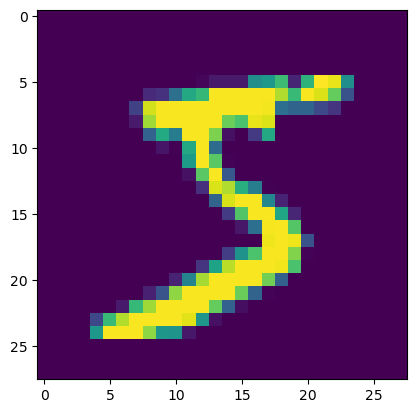

In [30]:
plt.imshow(mnist[0][0][0]);

## Torchvision datasets

The ```torchvision``` package also provides a dedicated object called ```ImageFolder``` which is capable of handling datasets sorted by classes and training/validation in separate folders. This reduced the need for file name parsing etc.

We take here as an example, the hymenoptera dataset whose structure is the following:
- train
    - ants
    - bees
- val
    - ants
    - bees
    
We can download these data in our ```data``` folder:

In [31]:
import zipfile
urllib.request.urlretrieve('https://download.pytorch.org/tutorial/hymenoptera_data.zip',
                          filename=datapath.joinpath('data/hymenoptera_data.zip'))
with zipfile.ZipFile(datapath.joinpath('data/hymenoptera_data.zip'), 'r') as zip_ref:
        zip_ref.extractall(datapath.joinpath('data/'))

And then we can pass e.g. the training folder directly to the ```ImageFolder``` object:

In [36]:
ants_bees = torchvision.datasets.ImageFolder(datapath.joinpath('data/hymenoptera_data/train'))

In [37]:
ants_bees.classes

['ants', 'bees']

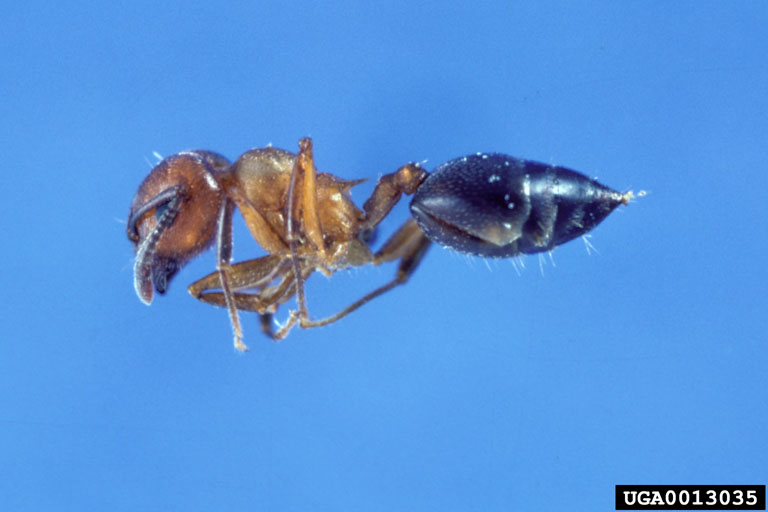

In [39]:
ants_bees[0][0]

This makes it very easy to create dataloaders for training and validations sets:

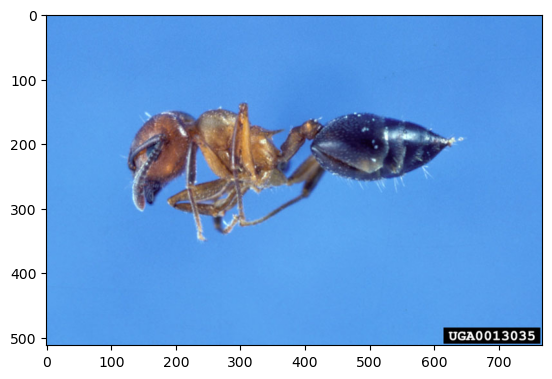

In [50]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

ants_bees_train = torchvision.datasets.ImageFolder(datapath.joinpath('data/hymenoptera_data/train'), transform=transforms)
ants_bees_valid = torchvision.datasets.ImageFolder(datapath.joinpath('data/hymenoptera_data/val'), transform=transforms)

ants_bees_train_loader = DataLoader(ants_bees_train)
ants_bees_valid_loader = DataLoader(ants_bees_valid)


plt.imshow(torch.moveaxis(next(iter(ants_bees_train_loader))[0][0], 0, 2));

## Exercise

In the folder data/drawings, you can find a series of .npy files containing images of little drawings. The names of the .npy files indicate what type of drawing the file contains. Try to create a dataset and dataloader for those files. It should return randomly images of 2-3 categories. Try to add some augmentation using a Transform.